In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.signal import convolve2d

In [2]:
# PARÂMETROS DO SISTEMA
L = 200  # tamanho
t0 = 0  # instante inicial
tf = 200  # instante final
gamma = 2 #largura da barreira
l = 10  # largura inicial do pacote <-- utilizado para ver múltiplas reflexões internas no caso da barreira dupla
x0 = -50 #posição inicial do pacote

# DISCRETIZAÇÃO
N = 400 # subdivisão espacial
n = 400 # subdivisão temporal
dx = L / N # passo espacial
dt = (tf - t0) / n # passo temporal
x = np.arange(N) * dx - L / 2  # vetor x espacial utilizado
kx = fft.fftfreq(N) * (2 * np.pi / dx) # vetor k no espaco recíproco
k0 = kx[kx > 1][0] # velocidade inicial do centro do pacote
p_max = np.pi/dx
t = np.arange(n) * dt + t0 # vetor t temporal utilizado

# FUNÇÃO DE ONDA INICIAL
psi_comeco = np.exp(-0.5 * (((x - x0) / l) ** 2)) * np.exp(1j * k0 * x)

#VALORES DE ALTURA DA BARREIRA GAUSSIANA
# v0=np.array([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
v0=np.array([0.0, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
# v0=0.5 dá para ver multiplas (3, 4) reflexoes internas, no caso da barreira dupla

<strong style="color: salmon; text-align:center;"><h1>Algoritmos para Dinâmica 1D</h1></strong>

In [3]:
# SPLIT-STEP
def split(
    dt,
    n_tempos,
    potential,
    potential_name,
    dx,
    psi_start,
    nome_salvarimg,
    snapshots=True,
    show_start=True,
):
    """
    dt --> passo de tempo

    n_tempos --> número total de passos de tempo

    potential --> potencial V(x)

    
    potential_name --> nome do potencial para ser plotado

    dx --> espaço k da FFT do vetor x utilizado

    psi_start --> função de onda para inicio da dinâmica

    nome_salvarimg --> nome utilizado para salvar as snapshots
    
    snapshots --> se False, não salva um plot matplotlib da função de onda para cada instante da dinâmica computada. O padrão é True

    show_start --> False caso snapshots False; caso snapshots True, permite ao usuário escolher se deseja, além de psi(t) para dado t da dinâmica, manter a (densidade de prob da) função de onda inicial no plot de para cada snapshot


    Retorna psi_tempos, uma coleção de vetores tais que psi_tempos[j] fornece o modulo quadrado da função de onda no j+1-esimo passo de tempo da dinâmica. 
    
    """

    H_k = 0.5 * (dx ** 2)  # energia cinetica no espaço k
    V_dt = lambda dt, potential: np.exp(
        -1j * (dt / 2) * potential
    )  # exponencial de Vdt/2
    H_dt = lambda dt, H_k: np.exp(
        -1j * dt * H_k
    )  # exponencial da parte cinética vezes dt
    psi_tempos = []

    psi_antes = np.copy(psi_start)

    if snapshots:
        if show_start:
            for j in range(n_tempos):
                plt.plot(
                    x, np.conjugate(psi_comeco) * psi_comeco, label="funcao inicial"
                )
                plt.plot(x, potential, label=potential_name)
                psi_depois = V_dt(dt, potential) * fft.ifft(
                    H_dt(dt, H_k) * fft.fft(V_dt(dt, potential) * psi_antes)
                )
                psi_squared = np.conjugate(psi_depois) * psi_depois
                plt.plot(x, psi_squared)
                psi_tempos.append(np.real(psi_squared))
                plt.legend()
                plt.tight_layout()
                plt.savefig("split-" + str(nome_salvarimg) +  "-i=" + str(j) + ".png", dpi=120)
                plt.close()
                psi_antes = np.copy(psi_depois)
        else:
            for j in range(n_tempos):
                plt.plot(x, potential, label=potential_name)
                psi_depois = V_dt(dt, potential) * fft.ifft(
                    H_dt(dt, H_k) * fft.fft(V_dt(dt, potential) * psi_antes)
                )
                psi_squared = np.conjugate(psi_depois) * psi_depois
                plt.plot(x, psi_squared)
                psi_tempos.append(np.real(psi_squared))
                plt.legend()
                plt.tight_layout()
                plt.savefig("split-" + str(nome_salvarimg) +  "-i=" + str(j) + ".png", dpi=120)
                plt.close()
                psi_antes = np.copy(psi_depois)
    else:
        show_start = False
        for j in range(n_tempos):
            psi_depois = V_dt(dt, potential) * fft.ifft(
                H_dt(dt, H_k) * fft.fft(V_dt(dt, potential) * psi_antes)
            )
            psi_squared = np.conjugate(psi_depois) * psi_depois
            psi_tempos.append(np.real(psi_squared))
            psi_antes = np.copy(psi_depois)           
    return psi_tempos

# CHEBYSHEV
def chebyshev(
    dt,
    dx,
    p_max,
    n_tempos,
    potential,
    potential_name,
    psi_start,
    nome_salvarimg,
    bessel_tol=1e-8,
    snapshots=True,
    show_start=True,
):
    """
    dt --> passo de tempo
    
    dx --> passo espacial 

    p_max --> maior valor do momento (usado para calcular E_max e normalizar a chebyshev)

    n_tempos --> número total de passos de tempo

    potential --> potencial V(x)

    potential_name --> nome do potencial para ser plotado

    psi_start --> função de onda para inicio da dinâmica

    nome_salvarimg --> nome utilizado para salvar as snapshots

    bessel_tol -->  erro tomado como critério de truncagem para obter a Bessel de ordem mais alta. default 10^-8

    snapshots --> se False, não salva um plot matplotlib da função de onda para cada instante da dinâmica computada. O padrão é True

    show_start --> False caso snapshots False; caso snapshots True, permite ao usuário escolher se deseja, além de psi(t) para dado t da dinâmica, manter a (densidade de prob da) função de onda inicial no plot de para cada snapshot


    Retorna psi_tempos, uma coleção de vetores tais que psi_tempos[j] fornece o modulo quadrado da função de onda no j+1-esimo passo de tempo da dinâmica.

    """

    # aplicamos convolução para calcular a atuação da parte cinetica em psi
    def H_cinetica(psi,dx):
        # H_k = 0.5 * (kx ** 2)  # energia cinetica no espaço k
        # return fft.ifft(H_k * fft.fft(psi))
        last = np.copy(psi[-1])
        first = np.copy(psi[0])
        return -(1/(2*dx*dx))*np.convolve(np.append(np.insert(psi,0,last), first), np.array([1, -2, 1]), mode="valid")

    # OBS:: na lambda para H_cinetica acima, np.append(np.insert(psi,0,psi[-1]), psi[0]) serve para criar um array maior, mimetizando condições de contorno periódicas; depois, usando o "valid", nos é retornado um vetor com o mesmo tamanho de psi.
    H_potencial = (
        lambda potential, psi: potential * psi
    )  # produto piece-wise para obter a ação do potencial sobre psi

    # ATUAÇÃO DE H (NORMALIZADO) SOBRE UMA DADA PSI
    H_psi = lambda dx, psi, potential, normaliz, E_min: (1 / normaliz) * (
        H_cinetica(psi, dx) + H_potencial(potential, psi) - E_min * np.ones_like(psi)
    )

    # No método de Chebyshev, precisamos estimar o maior e menor autovalor do hamiltoniano do sistema.
    V_max = np.sort(potential)[-1]
    print("V_max", V_max)
    E_max = 0.5 * (p_max ** 2) + V_max
    E_min = 0  # TENTANDO ESCOLHER UM BOM E_MIN SEM FAZER CONTA...
    # E_min = -E_max  # TENTANDO ESCOLHER UM BOM E_MIN SEM FAZER CONTA...

    normaliz = E_max - E_min
    # normaliz = (.5*k)**2

    alpha = normaliz * dt #ou tau
    print("alpha=", alpha)

    # Agora, devemos obter o maior valor da ordem de função Bessel a ser utilizada para nossa expansão de Chebyshev
    converged = False
    collected_bessels = [jv(0, alpha)]

    l = 1
    while not converged:
        collected_bessels.append(2 * ((-1j) ** l) * jv(l, alpha))
        if np.abs(2 * jv(l, alpha)) < bessel_tol:
            converged = True
        l += 1
    collected_bessels = np.array(collected_bessels)
    n_max = l
    print("utilizaremos n_max =", n_max)

    # Uma vez que temos as Bessel, devemos aplicar a recorrência de Chebyshev para obter todas psi_n relevantes
    def chebyshev_recurrence(psi_start, n_max, dx, potential, normaliz, H_psi, E_min):
        # esperamos que psi_start seja um vetor numpy
        psi_list = [0] * n_max
        psi_list[0] = psi_start
        psi_list[1] = H_psi(dx, psi_start, potential, normaliz, E_min)
        for j in range(2, n_max):
            psi_list[j] = (
                2 * H_psi(dx, psi_list[j - 1], potential, normaliz, E_min)
            ) - psi_list[j - 2]
        # retorna as psi_n que devem ser utilizadas na expansão
        return np.array(psi_list)

    psi_tempos = []

    psi_antes = np.copy(psi_start)

    if snapshots:
        if show_start:
            for j in range(n_tempos):
                plt.plot(
                    x, np.conjugate(psi_comeco) * psi_comeco, label="funcao inicial"
                )
                plt.plot(x, potential, label=potential_name)
                chebyshev_selection = chebyshev_recurrence(
                    psi_antes, l, dx, potential, normaliz, H_psi, E_min
                )
                psi_depois = np.sum(
                    np.array(
                        [
                            collected_bessels[m] * chebyshev_selection[m]
                            for m in range(n_max)
                        ]
                    ),
                    axis=0,
                )
                psi_squared = np.conjugate(psi_depois) * psi_depois
                plt.plot(x, psi_squared)
                psi_tempos.append(np.real(psi_squared))
                plt.legend()
                plt.tight_layout()
                plt.savefig(
                    "chebyshev-" + str(nome_salvarimg) + "-i=" + str(j) + ".png", dpi=120
                )
                plt.close()
                psi_antes = np.copy(psi_depois)
        else:
            for j in range(n_tempos):
                plt.plot(x, potential, label=potential_name)
                chebyshev_selection = chebyshev_recurrence(
                    psi_antes, l, dx, potential, normaliz, H_psi, E_min
                )
                psi_depois = np.sum(
                    np.array(
                        [
                            collected_bessels[m] * chebyshev_selection[m]
                            for m in range(n_max)
                        ]
                    ),
                    axis=0,
                )
                psi_squared = np.conjugate(psi_depois) * psi_depois
                plt.plot(x, psi_squared)
                psi_tempos.append(np.real(psi_squared))
                plt.legend()
                plt.tight_layout()
                plt.savefig(
                    "chebyshev-" + str(nome_salvarimg) + "-i=" + str(j) + ".png", dpi=120
                )
                plt.close()
                psi_antes = np.copy(psi_depois)
    else:
        show_start = False
        for j in range(n_tempos):
            chebyshev_selection = chebyshev_recurrence(
                psi_antes, l, dx, potential, normaliz, H_psi, E_min
            )
            psi_depois = np.sum(
                np.array(
                    [
                        collected_bessels[m] * chebyshev_selection[m]
                        for m in range(n_max)
                    ]
                ),
                axis=0,
            )
            psi_squared = np.conjugate(psi_depois) * psi_depois
            psi_tempos.append(np.real(psi_squared))
            psi_antes = np.copy(psi_depois)

    return psi_tempos


<strong style="color: salmon; text-align:center;"><h1>Função auxiliar para plot imshow dinâmica 1D</h1></strong>


In [4]:
def plot_imshow(psi_tempos, tempos, x_centro, xinicio, xfim, k0, nome_imagem):
  """
  psi_tempos --> lista com a função de onda a cada instante (psi_tempos[j])
  
  tempos --> vetor com os instantes de tempo da dinâmica
  
  x_centro --> centro da função de onda inicial
  
  xinicio --> posição inicial do plot no eixo vertical
  
  xfim --> posição final do plot no eixo vertical
  
  k0 --> velocidade inicial do pacote de onda inicial
  
  nome_imagem --> nome do arquivo png que será gerado
  """
  plt.imshow(psi_tempos.T, aspect='auto', origin="lower", cmap="jet", extent=[tempos[0], tempos[-1], xinicio, xfim], vmax=1)
  plt.plot(tempos, x_centro + k0*tempos, c='white')
  plt.axhline(0, c='white', lw=5)
  plt.ylim(-L/2, L/2)
  plt.xlabel(r'$t$')
  plt.ylabel(r'$x$')
  plt.tight_layout()
  plt.savefig(nome_imagem+".png", dpi=120)
  plt.show()

<strong style="color: salmon; text-align:center;"><h1>Barreira Simples via Split-Step</h1></strong>


/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

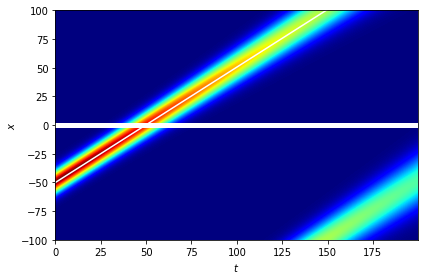

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

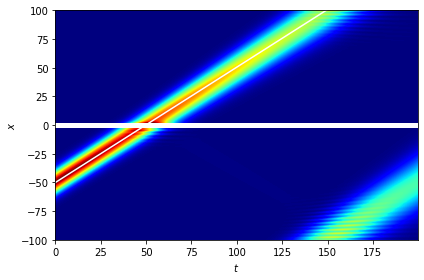

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

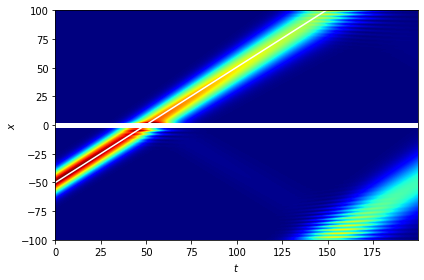

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

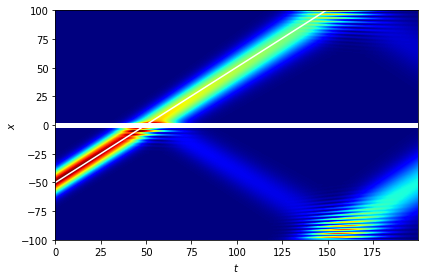

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

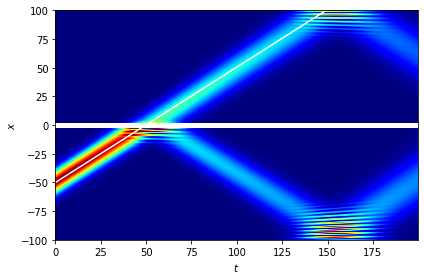

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

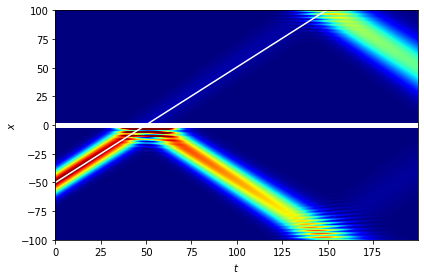

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

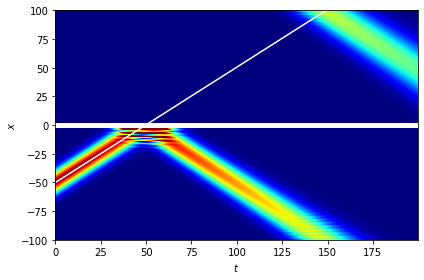

/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rafaelcosta/.local/lib/python

KeyboardInterrupt: 

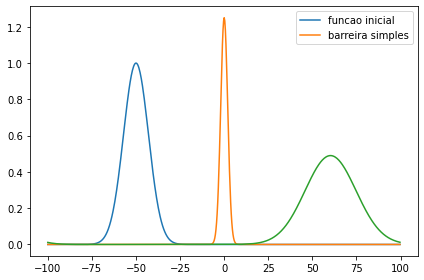

In [5]:
V_simples = lambda v0, center, width: v0*(np.exp(-.5*(((x-center)/width)**2)))
for altura in v0:
  psi_tempos = split(dt, n, V_simples(altura,0, gamma), "barreira simples", kx, psi_comeco, "SIMPLES-V0=" +str(altura))
  plot_imshow(np.array(psi_tempos), t, x0, x[0], x[-1], k0, "split-step-SIMPLES-v0="+str(altura))

<strong style="color: salmon; text-align:center;"><h1>Barreira Simples via Chebyshev</h1></strong>

In [ ]:
V_simples = lambda v0, center, width: v0 * (
    np.exp(-0.5 * (((x - center) / width) ** 2))
)
for altura in v0:
    psi_tempos = chebyshev(
        dt,
        dx,
        p_max,
        n,
        V_simples(altura, 0, gamma),
        "barreira simples",
        psi_comeco,
         "SIMPLES-V0=" +str(altura),
    )
    plot_imshow(
        np.array(psi_tempos), t, x0, x[0], x[-1], k0, "chebyshev-SIMPLES-v0=" + str(altura)
    )


<strong style="color: salmon; text-align:center;"><h1>Barreira Dupla via Split-Step</h1></strong>

In [ ]:
V_dupla = lambda v0, center1, center2, width: v0*(np.exp(-.5*(((x-center1)/width)**2))) + v0*(np.exp(-.5*(((x-center2)/width)**2)))
for altura in v0[1:]:
  psi_tempos = split(dt, n, V_dupla(altura,-10*gamma, 5*gamma, gamma), "barreira dupla", kx, psi_comeco,  "DUPLA-V0=" +str(altura))
  plot_imshow(np.array(psi_tempos), t, x0, x[0], x[-1], k0, "split-step-DUPLA-v0="+str(altura))

<strong style="color: salmon; text-align:center;"><h1>Barreira Dupla via Chebyshev</h1></strong>

In [ ]:
V_dupla = lambda v0, center1, center2, width: v0 * (
    np.exp(-0.5 * (((x - center1) / width) ** 2))
) + v0 * (np.exp(-0.5 * (((x - center2) / width) ** 2)))
for altura in v0[1:]:
    psi_tempos = chebyshev(
        dt,
        dx,
        p_max,
        n,
        V_dupla(altura, -10 * gamma, 5 * gamma, gamma),
        "barreira dupla",
        psi_comeco,
        "DUPLA-V0=" + str(altura),
    )
    plot_imshow(
        np.array(psi_tempos),
        t,
        x0,
        x[0],
        x[-1],
        k0,
        "chebyshev-DUPLA-v0=" + str(altura),
    )

<strong style="color: salmon; text-align:center;"><h1>Algoritmo para Dinâmica 2D (desafio)</h1></strong>

In [ ]:
# CHEBYSHEV 2D
def chebyshev2d(
    L,
    dt,
    dx,
    p_max,
    V_max,
    n_tempos,
    x_centro,
    k0,
    potential,
    potential_name,
    psi_start,
    nome_salvarimg,
    bessel_tol=1e-8,
    snapshots=True,
    show_start=True,
):
    """
    L --> tamanho do sistema (pressupõe rede quadrada)

    dt --> passo de tempo

    dx --> passo espacial (essa implementação pressupõe o mesmo passo de discretização em x e y)

    p_max --> maior valor do momento (usado para calcular E_max e normalizar a chebyshev)

    V_max --> maior valor do potencial (usado para calcular E_max e normalizar a chebyshev)

    n_tempos --> número total de passos de tempo
    
    x_centro --> centro em x da função de onda inicial (pressupõe dinâmica ao longo de x)
    
    k0,

    potential --> potencial V(x,y)

    potential_name --> nome do potencial para ser plotado

    psi_start --> função de onda para inicio da dinâmica (psi(x,y))

    nome_salvarimg --> nome utilizado para salvar as snapshots

    bessel_tol -->  erro tomado como critério de truncagem para obter a Bessel de ordem mais alta. default 10^-8

    snapshots --> se False, não salva um plot matplotlib (imshow) da função de onda para cada instante da dinâmica computada. O padrão é True

    show_start --> False caso snapshots False; caso snapshots True, permite ao usuário escolher se deseja, além de psi(t) para dado t da dinâmica, manter a (densidade de prob da) função de onda inicial no plot de para cada snapshot
    
    FIXME>>> pensar se vale a pena retornar, ou se vamos apenas plotar... num cenário realista, salvaríamos a matriz psi(x,y) para cada instante de tempo e não manteríamos um vetor com todas essas matrizes!!!
    
    # UPDATE: na versão atual, não retornamos psi_tempos
    
    Retorna psi_tempos, uma coleção de "matrizes" tais que psi_tempos[j] fornece o modulo quadrado da função de onda no j+1-esimo passo de tempo da dinâmica. Dizemos "matrizes" porque na verdade trata-se dos valores psi(x,y) na rede discretizada.

    """
    # aplicamos convolução para calcular a atuação da parte cinetica em psi
    def H_cinetica(psi, dx):
        kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        return -(1 / (2 * dx * dx)) * convolve2d(
            psi, kernel, mode="same", boundary="wrap"
        )

    H_potencial = (
        lambda potential, psi: potential * psi
    )  # produto piece-wise para obter a ação do potencial sobre psi

    # ATUAÇÃO DE H (NORMALIZADO) SOBRE UMA DADA PSI (espera-se que psi seja um numpy array 2d)
    H_psi = lambda dx, psi, potential, normaliz, E_min: (1 / normaliz) * (
        H_cinetica(psi, dx) + H_potencial(potential, psi) - E_min * np.eye(psi[0].size)
    )

    # No método de Chebyshev, precisamos estimar o maior e menor autovalor do hamiltoniano do sistema.
    # V_max = np.sort(potential)[-1] #<< FIXME: ADICIONAR V_max como parâmetro obrigatório para chamar a função!
    print("V_max", V_max)
    E_max = (p_max ** 2) + V_max  # (supomos Px_max = Py_max)
    E_min = 0  # TENTANDO ESCOLHER UM BOM E_MIN SEM FAZER CONTA...
    # E_min = -E_max  # TENTANDO ESCOLHER UM BOM E_MIN SEM FAZER CONTA...

    normaliz = E_max - E_min

    alpha = normaliz * dt
    print("alpha=", alpha)

    # Agora, devemos obter o maior valor da ordem de função Bessel a ser utilizada para nossa expansão de Chebyshev
    converged = False
    collected_bessels = [jv(0, alpha)]
    l = 1
    while not converged:
        collected_bessels.append(2 * ((-1j) ** l) * jv(l, alpha))
        if np.abs(2 * jv(l, alpha)) < bessel_tol:
            converged = True
        l += 1
    collected_bessels = np.array(collected_bessels)
    n_max = l
    print("utilizaremos n_max =", n_max)

    # Uma vez que temos as Bessel, devemos aplicar a recorrência de Chebyshev para obter todas psi_n relevantes
    def chebyshev_recurrence(psi_start, n_max, dx, potential, normaliz, H_psi, E_min):
        # esperamos que psi_start seja um numpy array 2d
        psi_list = [0] * n_max
        psi_list[0] = psi_start
        psi_list[1] = H_psi(dx, psi_start, potential, normaliz, E_min)
        for j in range(2, n_max):
            psi_list[j] = (
                2 * H_psi(dx, psi_list[j - 1], potential, normaliz, E_min)
            ) - psi_list[j - 2]
        # retorna as psi_n que devem ser utilizadas na expansão
        return np.array(psi_list)

    # psi_tempos = []

    psi_antes = np.copy(psi_start)

    if snapshots:
        if show_start:
            for j in range(n_tempos):
                chebyshev_selection = chebyshev_recurrence(
                    psi_antes, l, dx, potential, normaliz, H_psi, E_min
                )
                psi_depois = np.sum(
                    np.array(
                        [
                            collected_bessels[m] * chebyshev_selection[m]
                            for m in range(n_max)
                        ]
                    ),
                    axis=0,
                )
                psi_squared = np.real(np.conjugate(psi_depois) * psi_depois)
                plt.imshow(
                    psi_squared + np.real(np.conjugate(psi_comeco) * psi_comeco) + potential,
                    aspect="auto",
                    origin="lower",
                    cmap="jet",
                    extent=[-L/2, L/2, -L/2, L/2],
                    vmax=.5*V_max,
                )
                # psi_tempos.append(psi_squared)
                plt.ylim(-L / 2, L / 2)
                plt.xlim(-L / 2, L / 2)
                plt.xlabel(r"$x$")
                plt.ylabel(r"$y$")
                plt.colorbar()
                plt.tight_layout()
                plt.savefig(
                    "chebyshev2D-" + str(nome_salvarimg) + "-i=" + str(j) + ".png",
                    dpi=120,
                )
                plt.close()
                psi_antes = np.copy(psi_depois)
                # por fim, salva a função de onda daquele instante da dinâmica em um arquivo binário
                np.save("chebyshev2D-" + str(nome_salvarimg) +"psi-i="+str(j),psi_antes)

        else:
            for j in range(n_tempos):
                chebyshev_selection = chebyshev_recurrence(
                    psi_antes, l, dx, potential, normaliz, H_psi, E_min
                )
                psi_depois = np.sum(
                    np.array(
                        [
                            collected_bessels[m] * chebyshev_selection[m]
                            for m in range(n_max)
                        ]
                    ),
                    axis=0,
                )
                psi_squared = np.real(np.conjugate(psi_depois) * psi_depois)
                plt.imshow(
                    psi_squared + potential,
                    aspect="auto",
                    origin="lower",
                    cmap="jet",
                    extent=[-L/2, L/2, -L/2, L/2],
                    vmax=.5*V_max,
                )
                # psi_tempos.append(psi_squared)
                plt.ylim(-L / 2, L / 2)
                plt.xlim(-L / 2, L / 2)
                plt.xlabel(r"$x$")
                plt.ylabel(r"$y$")
                plt.colorbar()
                plt.tight_layout()
                plt.savefig(
                    "chebyshev2D-" + str(nome_salvarimg) + "-i=" + str(j) + ".png",
                    dpi=120,
                )
                plt.close()
                psi_antes = np.copy(psi_depois)
                # por fim, salva a função de onda daquele instante da dinâmica em um arquivo binário
                np.save("chebyshev2D-" + str(nome_salvarimg) +"psi-i="+str(j),psi_antes)
    else:
        show_start = False
        for j in range(n_tempos):
            chebyshev_selection = chebyshev_recurrence(
                psi_antes, l, dx, potential, normaliz, H_psi, E_min
            )
            psi_depois = np.sum(
                np.array(
                    [
                        collected_bessels[m] * chebyshev_selection[m]
                        for m in range(n_max)
                    ]
                ),
                axis=0,
            )
            psi_squared = np.conjugate(psi_depois) * psi_depois
            # psi_tempos.append(np.real(psi_squared))
            psi_antes = np.copy(psi_depois)
            # por fim, salva a função de onda daquele instante da dinâmica em um arquivo binário
            np.save("chebyshev2D-"+ str(nome_salvarimg) +"psi-i="+str(j),psi_antes)
            
    return 1


<strong style="color: salmon; text-align:center;"><h1>Preparando o sistema para fazer as coisas em 2D</h1></strong>

In [ ]:
# Discretizando pontos em 2D
# PARÂMETROS DO SISTEMA
L = 200  # tamanho
t0 = 0  # instante inicial
tf = 200  # instante final
l = 5  # largura inicial do pacote
x0, y0 = -L/4, 0 #posição inicial do pacote

# DISCRETIZAÇÃO
N = 400 # subdivisão espacial
n = 400 # subdivisão temporal
dx = L / N # passo espacial
dt = (tf - t0) / n # passo temporal
x = np.arange(N) * dx - L/2  # vetor x espacial utilizado
y = np.arange(N) * dx - L/2
# meshgrid: converte vetores x,y em matrizes de coordenadas
X, Y = np.meshgrid(x,y)
kx = fft.fftfreq(N) * (2 * np.pi / dx) # vetor k no espaco recíproco
k0 = kx[kx > 1][0] # velocidade inicial do centro do pacote
p_max = np.pi/dx #cutoff uv do momento devido a discretização (h_barra = 1)
t = np.arange(n) * dt + t0 # vetor t temporal utilizado

# FUNÇÃO DE ONDA INICIAL
psi_comeco = np.exp(-0.5 * ((((X - x0)**2) + ((Y - y0)**2))/(l**2))) * np.exp(1j * k0 * X)

#VALORES DE ALTURA DA BARREIRA UTILIZADA PARA CONSTRUIR A(S) BARREIRA(S)
# v0=np.array([0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
v0=np.array([0.0, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])


<strong style="color: salmon; text-align:center;"><h1>Fenda Simples 2D (desafio)</h1></strong>

In [ ]:
# espessura da fenda (em x)
a=(8/100)*L
# abertura da fenda (em y)
b=(2/100)*L
# FUNÇÃO DE ONDA INICIAL
psi_comeco = np.exp(-0.5 * ((((X - x0)**2) + ((Y - y0)**2))/(l**2))) * np.exp(1j * k0 * X)
# centro das fendas (simetrizadas em torno de y=0)
# potencial
fenda_simples = np.real(np.zeros_like(psi_comeco))
fenda_simples[(np.abs(X) < a/2) & (np.abs(Y) > b/2)]=1
altura = 2.0
chebyshev2d(L, dt, dx, p_max, altura, n, x0, k0, altura*fenda_simples, "fenda simples", 5*psi_comeco, "SIMPLES-v0="+str(altura), show_start=False)

<strong style="color: salmon; text-align:center;"><h1>Fenda Dupla 2D (desafio)</h1></strong>

In [ ]:
# espessura da fenda (em x)
a=(8/100)*L
# abertura da fenda (em y)
b=(2/100)*L
# centro das fendas (simetrizadas em torno de y=0)
centro=(L/4) - 40
# FUNÇÃO DE ONDA INICIAL (mais larga em y, PARA FAZER fendas distantes)
psi_comeco = np.exp(-0.5 * ((((X - x0)**2) + (((Y - y0)**2)/10))/(l**2))) * np.exp(1j * k0 * X)
fenda_dupla = np.real(np.zeros_like(psi_comeco))
# FENDAS
fenda_dupla[(np.abs(X) < a/2) & (np.abs(Y-centro) > b/2)]=1
fenda_dupla[(np.abs(X) < a/2) & (np.abs(Y+centro) <= b/2)]=0
altura = 2.0
chebyshev2d(L, dt, dx, p_max, altura, n, x0, k0, altura*fenda_dupla, "fenda dupla distante", 5*psi_comeco, "FENDAS-DISTANTES-v0="+str(altura), show_start=False)

<strong style="color: salmon; text-align:center;"><h1>Fenda Dupla 2D -- Babinet? (desafio)</h1></strong>

In [ ]:
# espessura do OBSTACULO (em x)
a=(8/100)*L
# abertura do OBSTACULO (em y)
b=(2/100)*L
# centro dos OBSTACULOs (simetrizados em torno de y=0)
centro=(L/4) - 40
# FUNÇÃO DE ONDA INICIAL (mais larga em y, PARA FAZER OBSTACULOs distantes)
psi_comeco = np.exp(-0.5 * ((((X - x0)**2) + (((Y - y0)**2)/10))/(l**2))) * np.exp(1j * k0 * X)
obstaculos_duplos = np.real(np.zeros_like(psi_comeco))
# OBSTÁCULOS
obstaculos_duplos[(np.abs(X) < a/2) & (np.abs(Y-centro) < b/2)]=1
obstaculos_duplos[(np.abs(X) < a/2) & (np.abs(Y+centro) < b/2)]=1
altura = 2.0
chebyshev2d(L, dt, dx, p_max, altura, n, x0, k0, altura*obstaculos_duplos, "obstaculos duplos distantes", 5*psi_comeco, "OBSTACULOS-DISTANTES-v0="+str(altura), show_start=False)